In [1]:
import matplotlib.pyplot as plt
import matplotlib.transforms as mtransforms
import json
import numpy as np

In [2]:
from utils import join_reference_set_and_results, compute_sign_rate_found

In [3]:
with open('observational_results.txt') as f:
    observational_results = [json.loads(a) for a in f]

fname = '../reference_set.txt'
title = 'Reference Set With Clinical Trial Quality Filters'

# fname = '../raw_reference_set.txt'
# title = 'Original Reference Set Without Filters'


# fname = '../multi_rct_reference_set.txt'
# title = 'Reference Set That Requires Multiple Trials'


title = None

with open(fname) as f:
    reference_set = [json.loads(a) for a in f]

# Illustrate the format of these files
print("Observational results are in the following format")
print(observational_results[0])
print()
print("The reference set is in the following format")
print(reference_set[0])

Observational results are in the following format
{'icd10codes': ['I21', 'I21.9'], 'atc_codes': [['A10BH01'], ['A10BA02']], 'results': {'cox': {'unadjusted': {'se': 0.027423460234602997, 'coef': 0.6649116462997681, 'p': 7.27115818984605e-130}, 'logistic_match': {'se': 0.03668112356057784, 'coef': 0.1318416921694853, 'p': 0.00032530814668214344}, 'lightgbm_match': {'se': 0.03665122519783611, 'coef': 0.24484905019566594, 'p': 2.38104429281256e-11}, 'logistic_ipw': {'se': 0.044480495055937465, 'coef': 0.09291333204879473, 'p': 0.036720721907434896}}, 'km': {'unadjusted': {'se': 3.0333777184930963, 'coef': -60.701237972185936, 'p': 0}, 'logistic_match': {'se': 3.340344516814828, 'coef': -6.197304215920212, 'p': 0}, 'lightgbm_match': {'se': 3.4244727494087375, 'coef': -16.578619802270623, 'p': 0}}}}

The reference set is in the following format
{'p': 0.6945612212128929, 'sub_infos': [{'side_effect_name': 'anaemia', 'drugs': ['Exemestane', 'Tamoxifen'], 'icd10codes': ['D64.9'], 'table': [[2,

In [4]:
joined = join_reference_set_and_results(reference_set, observational_results)
filtered = [a for a in joined if 'postmean' in a]

sorted_by_bayes = sorted(filtered, key=lambda v: v['postmean'])
print('Example entry: ', sorted_by_bayes[0])

Example entry:  {'p': 1.293716498443211e-11, 'sub_infos': [{'side_effect_name': 'hiccups', 'drugs': ['Nicotine Lozenge', 'Bupropion'], 'icd10codes': ['R06.6'], 'table': [[35, 225], [0, 264]], 'study': 'nct/NCT0033xxxx/NCT00332644.xml', 'atc_codes': [['N07BA01'], ['N06AX12']]}], 'postmean': -4.071212328880102, 'icd10codes': ['R06.6'], 'table': [[0.0, 264.0], [35.0, 225.0]], 'lower': 0.014995576820477703, 'upper': 0.13945685621505094, 'atc_codes': [['N06AX12'], ['N07BA01']], 'results': {'cox': {'unadjusted': {'p': 0.024274506444446252, 'se': 0.1406162198575253, 'coef': -0.3167741030479668}, 'logistic_match': {'p': 0.25909571488072036, 'se': 0.24818599187249504, 'coef': 0.28008559592399324}, 'lightgbm_match': {'p': 0.14316708359883817, 'se': 0.21602626338359263, 'coef': 0.3162836913945771}, 'logistic_ipw': {'p': 0.46453677394054704, 'se': 0.29105359082606375, 'coef': 0.21287568657593273}}, 'km': {'unadjusted': {'p': 0, 'se': 0.3851653065587371, 'coef': 1.0348673696025799}, 'logistic_match

{'a)': <Axes: label='a)'>, 'b)': <Axes: label='b)'>}
For method Unadjusted Cox, 71.67% are statistically significant
For method PSM Cox, 29.05% are statistically significant
For method IPSW Cox, 22.19% are statistically significant


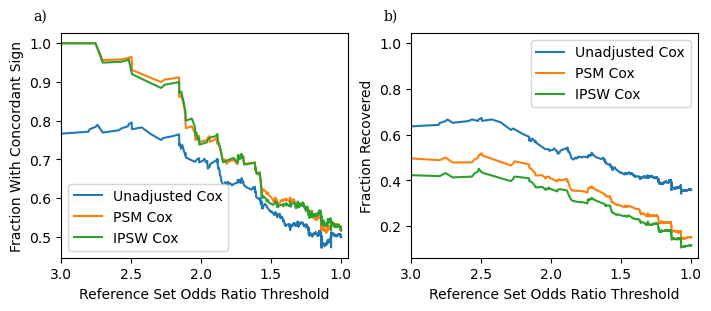

In [5]:
methods = {
    'unadjusted': 'Unadjusted Cox',
    'logistic_match': 'PSM Cox',
    'logistic_ipw': 'IPSW Cox',
}

fig, axs = plt.subplot_mosaic([['a)', 'b)']],
                              layout='constrained', figsize=(7, 3))
print(axs)
for label, ax in axs.items():
    # label physical distance to the left and up:
    trans = mtransforms.ScaledTranslation(-20/72, 7/72, fig.dpi_scale_trans)
    ax.text(0.0, 1.0, label, transform=ax.transAxes + trans,
            fontsize='medium', va='bottom', fontfamily='serif')


for method_key, method_name in methods.items():
    postmean, fraction_correct, fraction_found, num_significant = compute_sign_rate_found(sorted_by_bayes, 'cox', method_key)
    print(f'For method {method_name}, {num_significant / len(sorted_by_bayes) * 100:0.2f}% are statistically significant')
    
    axs['a)'].plot(postmean, fraction_correct, label=method_name)
    axs['b)'].plot(postmean, fraction_found, label=method_name)

axs['a)'].set_xlim(3, 0.95)
axs['a)'].legend()
axs['a)'].set_xlabel("Reference Set Odds Ratio Threshold")
axs['a)'].set_ylabel("Fraction With Concordant Sign")


axs['b)'].set_xlim(3, 0.95)
axs['b)'].legend()
axs['b)'].set_xlabel("Reference Set Odds Ratio Threshold")
axs['b)'].set_ylabel("Fraction Recovered")

if title:
    fig.suptitle(title)

fig.savefig(fname.replace('.txt', '.pdf'))